<a href="https://colab.research.google.com/github/Kushvith/tenserflow/blob/main/transferlearning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import zipfile
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()


--2023-09-01 15:10:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   191MB/s    in 0.8s    

2023-09-01 15:10:19 (191 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [18]:
#how many images in each folder
import os

for dir_path,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 10 directori

## Creating data loaders (preparing data)
we will use the   `Image generartor` class load the images into batches

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_Shape = (224,224)
Batch_Size = 32
Ecpochs =5
main_dir = "10_food_classes_10_percent/"
train_dir = main_dir + "train/"
test_dir = main_dir +"test/"

train_datagen = ImageDataGenerator(
    rescale = 1/255.,
)
test_datagen = ImageDataGenerator(rescale= 1/255.)

print("Training Images: ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = Image_Shape,
    batch_size = Batch_Size,
    class_mode = 'categorical'
)
print("Testing Images: ")

test_data_10_percent = train_datagen.flow_from_directory(
    test_dir,
    target_size = Image_Shape,
    batch_size = Batch_Size,
    class_mode = 'categorical'
)

Training Images: 
Found 750 images belonging to 10 classes.
Testing Images: 
Found 2500 images belonging to 10 classes.


##setting up the callbacks (things to run the withlist  with extra functionality)
callbacks are extra functionality you can add to ur models
to be performed during or after the training
* tracking the experiments with the tensorboard
* model checkpoint with modelCheckPoint
* stopping the model from training (before it trains too long and overfits) with the earlycheckpoints

In [20]:
# create tensor board callback
import datetime

def create_tensorboard_callback(dirname,experiment_name):
  log_dir = dirname+ "/"+experiment_name+"/"+datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving the Tensorboard log files to:{log_dir} ')
  return tensorboard_callback

## creating the models using the tensorflow hub
in the we are building the model from the scrach
now we are going  to do a similar process expect the majority of the model layers are going to come from the tensor flow hub.
we can access the models on tensorflowhub https://tfhub.dev/
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [21]:
  efficient_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
  resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"



In [22]:
#import dependenices
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [23]:
def create_model(model_url,num_classes=10):
  '''
    takes a tensorflow hub url and creates a keras sequential model with it
    args:
        model url (str): A tensorflow hub feature extraction URL.
        num_classes (int): number of output neurons in the output layer
    return :
      an uncompiled keras sequential model with the model_uel a feature extractor
  '''
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extaction_layer",
                                           input_shape = Image_Shape+(3,))
  #create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model


#creating and testing the resnet model using the tensorflow hub

In [24]:
#create resnet model
res_net_model = create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [25]:
#compile the resnet model
res_net_model.compile(
    loss="categorical_crossentropy",
    optimizer= tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [26]:
res_net_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extaction_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
# lets fit the resnet model to data
res_net_history = res_net_model.fit(train_data_10_percent,
                                    epochs=5,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data_10_percent,
                                    validation_steps=len(test_data_10_percent),
                                    callbacks=[create_tensorboard_callback(dirname="tensorflow_hub",experiment_name="resnetv250")]
                                    )

Saving the Tensorboard log files to:tensorflow_hub/resnetv250/230901-151028 
Epoch 1/5
24/24 [==============================] - 26s 553ms/step - loss: 1.8426 - accuracy: 0.3773 - val_loss: 1.1865 - val_accuracy: 0.6380
Epoch 2/5
24/24 [==============================] - 11s 459ms/step - loss: 0.8875 - accuracy: 0.7320 - val_loss: 0.8822 - val_accuracy: 0.7104
Epoch 3/5
24/24 [==============================] - 13s 550ms/step - loss: 0.6110 - accuracy: 0.8240 - val_loss: 0.7398 - val_accuracy: 0.7680
Epoch 4/5
24/24 [==============================] - 10s 447ms/step - loss: 0.4657 - accuracy: 0.8653 - val_loss: 0.7045 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 10s 445ms/step - loss: 0.3714 - accuracy: 0.9133 - val_loss: 0.6667 - val_accuracy: 0.7904


wow!

that is incredible our transfer learning feature extractor model performed all of we built **previous**

In [28]:
# lets create the function to create the loss curves
import matplotlib.pyplot as plt

def create_plot_graph(history):
  '''
    returns seperate loss curves for training and validation metrics

    Args:
      history: Tensorflow History object

    Returns:
      plots of training/validation loss and accuracy matrics.
  '''
  loss = history.history['loss']
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.legend()

   #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.legend()

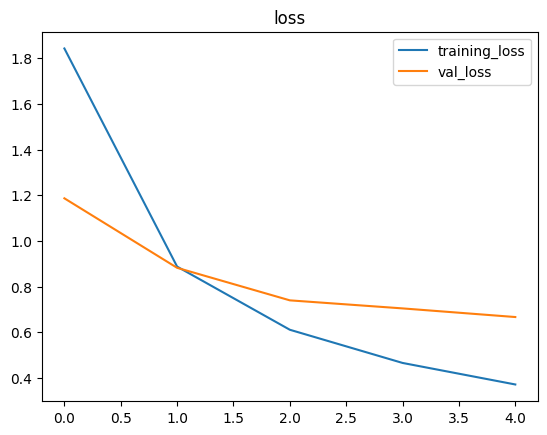

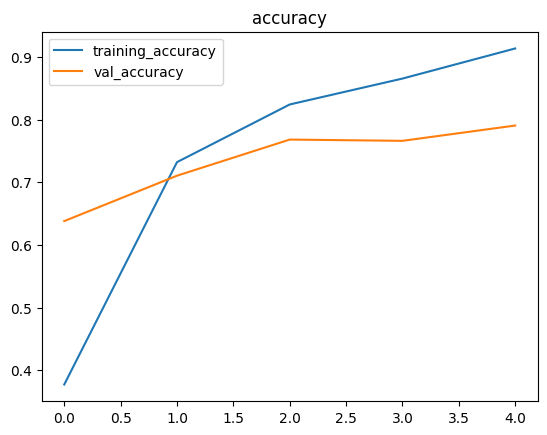

In [29]:
create_plot_graph(res_net_history)

# creating and testing Efficent bo model using tensorflow hub

In [30]:
efficent_model = create_model(efficient_url,train_data_10_percent.num_classes)

In [31]:
efficent_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),

    metrics=["accuracy"]
)

In [32]:
efficentmodel_history = efficent_model.fit(
    train_data_10_percent,
    epochs = 5,
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    steps_per_epoch=len(train_data_10_percent),
    callbacks=[create_tensorboard_callback(dirname="tensorflow_hub",experiment_name="efficent_net_v0")]
)

Saving the Tensorboard log files to:tensorflow_hub/efficent_net_v0/230901-151215 
Epoch 1/5
24/24 [==============================] - 24s 563ms/step - loss: 1.8654 - accuracy: 0.4267 - val_loss: 1.2955 - val_accuracy: 0.7432
Epoch 2/5
24/24 [==============================] - 9s 402ms/step - loss: 1.0840 - accuracy: 0.7680 - val_loss: 0.8705 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 9s 392ms/step - loss: 0.7702 - accuracy: 0.8240 - val_loss: 0.7009 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 10s 419ms/step - loss: 0.6237 - accuracy: 0.8627 - val_loss: 0.6140 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 10s 418ms/step - loss: 0.5255 - accuracy: 0.8853 - val_loss: 0.5581 - val_accuracy: 0.8620


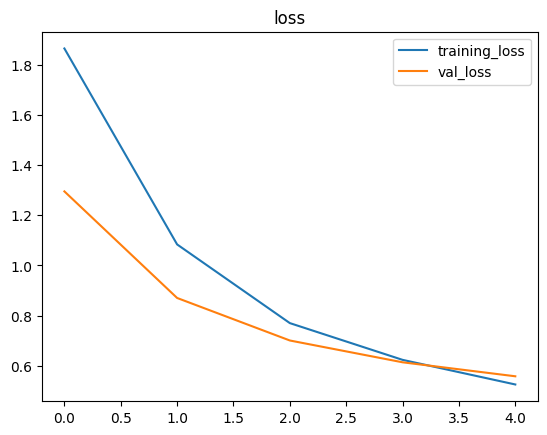

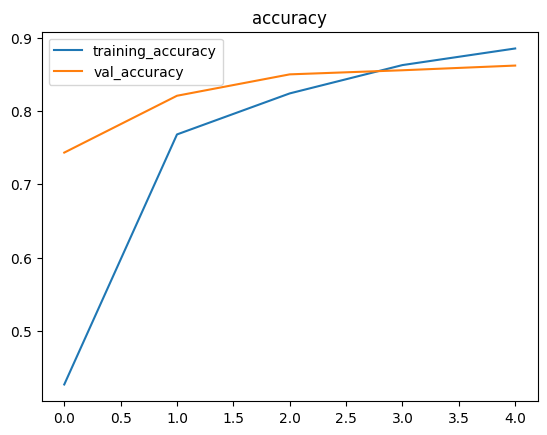

In [33]:
create_plot_graph(efficentmodel_history)

In [34]:
efficent_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extaction_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


#different types of transfer learning

* "As is" transfer learning using the existing model
* feature extraction  transfer learning - using the prellearned patterns for existing model
* fine-tuning

In [35]:
!nvidia-smi

Fri Sep  1 15:13:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   80C    P0    44W /  70W |   4939MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##creating the bunch of helper functions
in previous notebooks we have build the different models we can use it here

In [36]:
!wget "https://raw.githubusercontent.com/Kushvith/tenserflow/main/helper_function.py"

--2023-09-01 15:13:18--  https://raw.githubusercontent.com/Kushvith/tenserflow/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py.1’

helper_function.py. 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-01 15:13:18 (114 MB/s) - ‘helper_function.py.1’ saved [10246/10246]



In [37]:
#Import the helper functions
from helper_function import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir

## lets get some data
this time we are going to see how we can use the pretrained models within `tf.keras.applications` and then apply them to our own model

In [38]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=Image_Shape,
    label_mode="categorical",
    batch_size=32
)
test_data_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=Image_Shape,
    label_mode="categorical",
    batch_size=32
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
# class names of dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

#using functional api

In [40]:
#  create base model tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model
base_model.trainable = False
# create inputs into model
inputs = tf.keras.layers.Input(shape=Image_Shape+(3,),name="input_layer")
# using model resnet50v2 normalizing the inputs (not needed for efficent net)
# x= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass the inputs to basemodel
x= base_model(inputs)
print(f"shape after passing inputs throught the base model:  {x.shape}")

# average pooll the iutputs to the base mode
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print(f"shape after passing inputs throught the base model:  {x.shape}")

#  create the output activation layers
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layers")(x)

# combine the inputs with the outps into the model
model_0 = tf.keras.Model(inputs,outputs)
# compile the model
model_0.compile(loss="categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(),
                 metrics= ['accuracy'])

history0_10_percent = model_0.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="feature_extraction")]
)

16705208/16705208 [==============================] - 0s 0us/step


shape after passing inputs throught the base model:  (None, 7, 7, 1280)
shape after passing inputs throught the base model:  (None, 1280)
Saving TensorBoard log files to: transfer_learning/feature_extraction/20230901-151326
Epoch 1/5
24/24 [==============================] - 24s 422ms/step - loss: 1.9225 - accuracy: 0.3920 - val_loss: 1.3382 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 7s 250ms/step - loss: 1.1293 - accuracy: 0.7427 - val_loss: 0.8977 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 8s 315ms/step - loss: 0.7997 - accuracy: 0.8253 - val_loss: 0.7003 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 8s 317ms/step - loss: 0.6519 - accuracy: 0.8533 - val_loss: 0.6238 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 5s 178ms/step - loss: 0.5518 - accuracy: 0.8693 - val_loss: 0.5653 - val_accuracy: 0.8618


In [41]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 68ms/step - loss: 0.5653 - accuracy: 0.8632


[0.5653235912322998, 0.8632000088691711]

In [42]:
# check the layers in the our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [43]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [44]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


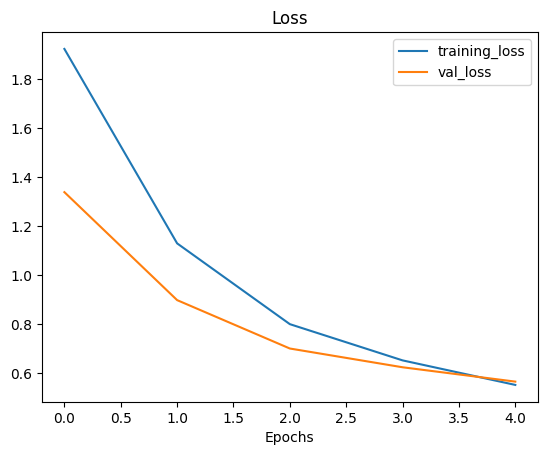

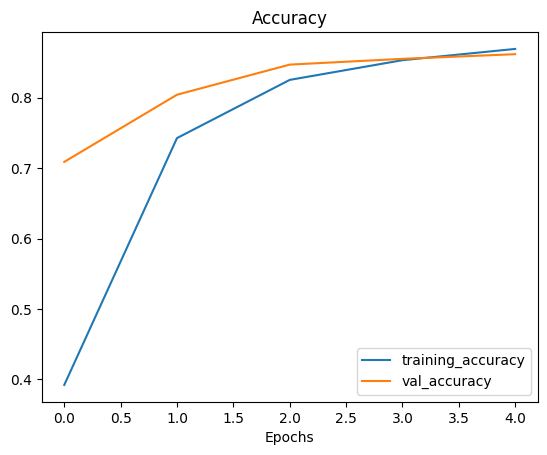

In [45]:
plot_loss_curves(history0_10_percent)

## Getting the featured vector
 lets demonstrate the globalaAverageLayer 2D
 (None,none,none,1280)
 to
 (none,1280)

In [46]:
#define the input shape
input_shape = (1,4,4,3)

# create the rNandom tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"the random input tensor:\n {input_tensor} \n")
# pass the random tensor to global average pooling
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2d global average pooled random tensor:\n {global_average_pooled_tensor}")
# check the shape of different tensor
print(f"the shape of the input tensor {input_tensor.shape}")
print(f"the shape of the global tensor {global_average_pooled_tensor.shape}")

the random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2d global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
the shape of the input tensor (1, 4, 4, 3)
the shape of the global tensor (1, 3)


In [47]:
# lets replicate the global average pool
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# Running the series of transfer learning

In [48]:
# download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-09-01 15:14:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   164MB/s    in 0.8s    

2023-09-01 15:14:38 (164 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [49]:
unzip_data('10_food_classes_1_percent.zip')

In [50]:
train_dir_1 = "10_food_classes_1_percent/train"
test_dir_1 = "10_food_classes_1_percent/test"

In [51]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

##model1 training with the transfer learning with the 1% of data

In [52]:
train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1,
    label_mode = "categorical",
    image_size=Image_Shape,
    batch_size =32
)
train_data_1 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_1,
    label_mode = "categorical",
    image_size=Image_Shape,
    batch_size =32
)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [54]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)
], name="data_argumentation")

10_food_classes_1_percent/train/fried_rice


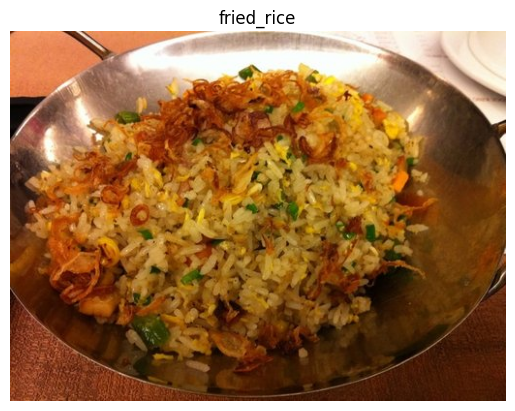

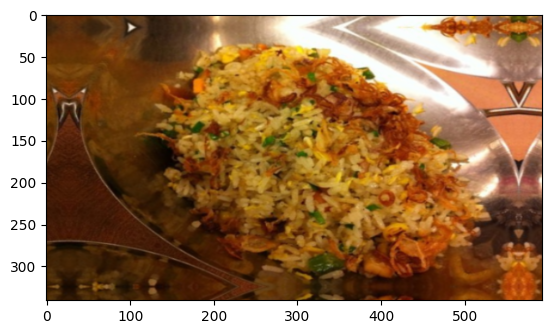

In [55]:
# visualize the data argumentation layer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir +"/"+random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False)
print(target_dir)
# lets plot our augumented image
augmented_image = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.0)

In [62]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
#  create the input layers
inputs = layers.Input(shape=input_shape,name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="average_pooling")(x)
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.Adam(),
    metrics=["accuracy"]
)
history1_10_percent = model_1.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data")]
)


Saving TensorBoard log files to: transfer_learning/1_percent_data/20230901-152741
Epoch 1/5
24/24 [==============================] - 24s 709ms/step - loss: 2.0361 - accuracy: 0.3427 - val_loss: 1.4630 - val_accuracy: 0.6382
Epoch 2/5
24/24 [==============================] - 15s 577ms/step - loss: 1.3390 - accuracy: 0.6760 - val_loss: 1.0164 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - 13s 532ms/step - loss: 1.0101 - accuracy: 0.7560 - val_loss: 0.7929 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 12s 481ms/step - loss: 0.8575 - accuracy: 0.8000 - val_loss: 0.6879 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 11s 429ms/step - loss: 0.7493 - accuracy: 0.8227 - val_loss: 0.6293 - val_accuracy: 0.8421


In [63]:
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_argumentation (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 average_pooling (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [65]:
result_1_percent_data = model_1.evaluate(test_data_10_percent)
result_1_percent_data

79/79 [==============================] - 7s 69ms/step - loss: 0.6353 - accuracy: 0.8368


[0.6353300213813782, 0.8367999792098999]

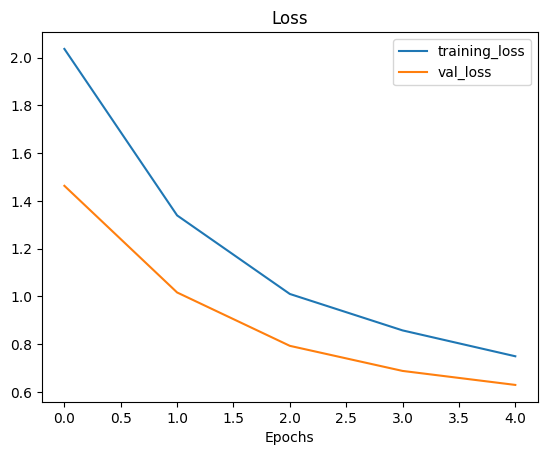

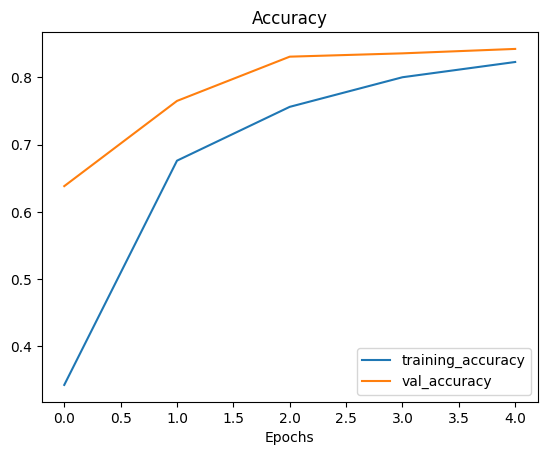

In [66]:
plot_loss_curves(history1_10_percent)

##model 2 feature extraction transfer learning model with 10% of data and data agumentation

In [68]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2023-09-01 15:37:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.171.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.171.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2023-09-01 15:37:53 (159 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [69]:
train_dir_10 = "10_food_classes_10_percent/train/"
test_dir_10 = "10_food_classes_10_percent/test/"

In [73]:
import tensorflow as tf
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10,
    label_mode = "categorical",
    image_size= Image_Shape
)
test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10,
    label_mode = "categorical",
    image_size= Image_Shape
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [76]:
data_argumentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
],name="data_argumentation")

In [83]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(input_shape,name="input_shape")
x = data_argumentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
output_layer = layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2 = keras.Model(
    inputs,output_layer
)
model_2.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = keras.optimizers.Adam(),
    metrics=["accuracy"]
)


In [79]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_argumentation (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

##create the model checkpoints

In [80]:
from keras.saving.saving_lib import save_weights_only
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints/checkpoint.ckpt"
# create the modelcheckpoint callback that saves the model weghts
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,save_best_only=False,verbose=1
)

In [95]:
history10_model_2 = model_2.fit(
    train_data_10,
    epochs=5,
    validation_data= test_data_10,
    validation_steps = int(0.35 * len(test_data_10)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data"),
               checkpoint_callback]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data/20230901-162519
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8760
Epoch 1: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 11s 454ms/step - loss: 0.4813 - accuracy: 0.8760 - val_loss: 0.4750 - val_accuracy: 0.8588
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8920
Epoch 2: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 14s 541ms/step - loss: 0.4604 - accuracy: 0.8920 - val_loss: 0.4439 - val_accuracy: 0.8738
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8907
Epoch 3: saving model to ten_percent_model_checkpoints/checkpoint.ckpt
24/24 [==============================] - 11s 416ms/step - loss: 0.4316 - accuracy: 0.8907 - val_loss: 0.4423 - val_accuracy: 0.8669
Epoch 4/5
24/24 [============

In [86]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 10s 118ms/step - loss: 0.5653 - accuracy: 0.8632


[0.5653236508369446, 0.8632000088691711]

In [96]:
results_10_percent = model_2.evaluate(test_data_10)

79/79 [==============================] - 6s 68ms/step - loss: 0.4498 - accuracy: 0.8680


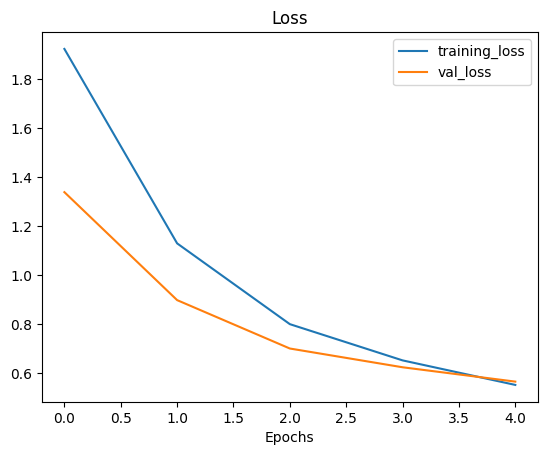

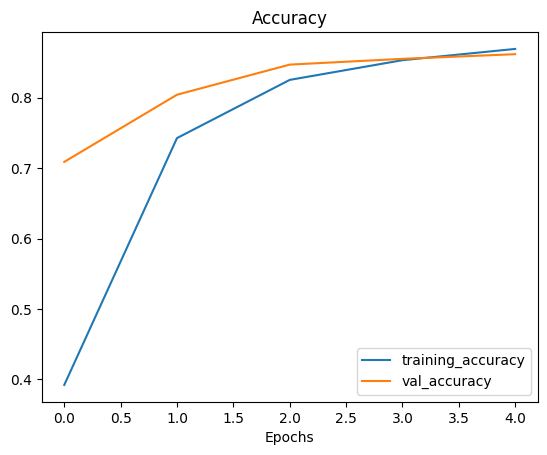

In [89]:
plot_loss_curves(history0_10_percent)

## Loading the checkpointed weights
Loadinf the checkpointed weights returns a model to a specific checkpoint

In [97]:
model_2.load_weights(checkpoint_path)

In [98]:
loaded_weight_results = model_2.evaluate(test_data_10)


79/79 [==============================] - 6s 69ms/step - loss: 0.4498 - accuracy: 0.8680


In [99]:
results_10_percent,loaded_weight_results

([0.44977763295173645, 0.8679999709129333],
 [0.4497776925563812, 0.8679999709129333])

In [100]:
#lets check the saved model and the result model is closest
import numpy as np
np.isclose(np.array(loaded_weight_results),np.array(results_10_percent))

array([ True,  True])

In [101]:
np.array(loaded_weight_results) - np.array(results_10_percent)

array([5.96046448e-08, 0.00000000e+00])